In [1]:
! mkdir ~/.kaggle

In [2]:
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download kaustubhb999/tomatoleaf

100% 178M/179M [00:10<00:00, 23.9MB/s]
100% 179M/179M [00:10<00:00, 17.6MB/s]


In [ ]:
! unzip /content/tomatoleaf.zip

In [6]:
import os
num_classes=len(os.listdir("/content/tomato/train"))
num_classes

10

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
training_set = train_datagen.flow_from_directory(
    '/content/tomato/train',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical' )

test_set=test_datagen.flow_from_directory(
    '/content/tomato/val',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical' )

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [11]:
label_map = (training_set.class_indices)

print(label_map)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___Septoria_leaf_spot': 4, 'Tomato___Spider_mites Two-spotted_spider_mite': 5, 'Tomato___Target_Spot': 6, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato___Tomato_mosaic_virus': 8, 'Tomato___healthy': 9}


In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

In [13]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [14]:
x = resnet50.output
x = GlobalAveragePooling2D()(x)

In [15]:
x = Dense(1024, activation='relu')(x)

In [16]:
x = Dropout(0.5)(x)

In [17]:
predictions = Dense(10, activation='softmax')(x)

In [18]:
model = Model(inputs=resnet50.input, outputs=predictions)

In [19]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit_generator(
    training_set,
    steps_per_epoch=100,
    epochs=10,
    validation_data=test_set,
    validation_steps=50)

<ipython-input-20-109c039e53e3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.9316 - accuracy: 0.7352

100/100 [==============================] - 87s 462ms/step - loss: 0.9316 - accuracy: 0.7352 - val_loss: 1830.8032 - val_accuracy: 0.1000
Epoch 2/10
100/100 [==============================] - 41s 406ms/step - loss: 0.3204 - accuracy: 0.8958
Epoch 3/10
100/100 [==============================] - 44s 439ms/step - loss: 0.3071 - accuracy: 0.9092
Epoch 4/10
100/100 [==============================] - 44s 440ms/step - loss: 0.4761 - accuracy: 0.8823
Epoch 5/10
100/100 [==============================] - 43s 429ms/step - loss: 0.1921 - accuracy: 0.9383
Epoch 6/10
100/100 [==============================] - 41s 410ms/step - loss: 0.1840 - accuracy: 0.9394
Epoch 7/10
100/100 [==============================] - 41s 404ms/step - loss: 0.1181 - accuracy: 0.9586
Epoch 8/10
100/100 [==============================] - 45s 444ms/step - loss: 0.1596 - accuracy: 0.9479
Epoch 9/10
100/100 [==============================] - 42s 423ms/step - loss: 0.1406 - accuracy: 0.9556
Epoch 10/10
100/100 [==================

In [26]:
model.evaluate(test_set,steps=100)

 16/100 [===>..........................] - ETA: 7s - loss: 4.6215 - accuracy: 0.3950

100/100 [==============================] - 2s 14ms/step - loss: 4.6215 - accuracy: 0.3950


[4.621527671813965, 0.39500001072883606]

In [34]:
model.save('resnet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
loaded_model = tf.keras.models.load_model("resnet50.h5")

In [39]:
num_samples = len(test_set.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

In [ ]:
for _ in range(num_batches):
    batch_images, batch_labels = next(test_set)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)

    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

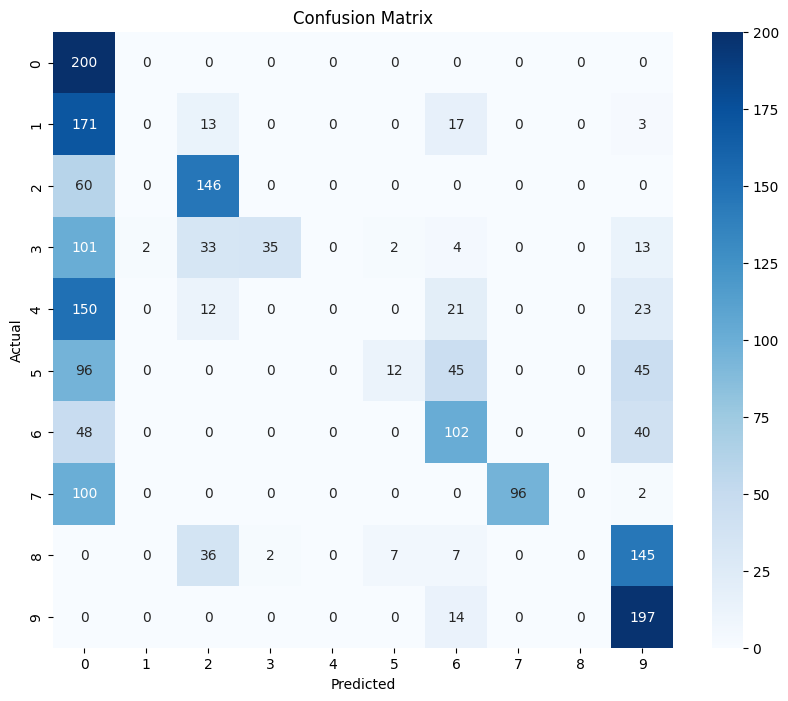

In [41]:
cm = confusion_matrix(all_test_labels, all_predicted_labels)

class_names = [str(i) for i in range(num_classes)]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()